In [8]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay

print("Using TensorFlow version:", tf.__version__)

# Pour reproduire un comportement stable (optionnel)
tf.random.set_seed(42)

Using TensorFlow version: 2.16.2


## 1. Chargement du dataset

In [ ]:
DATA_DIR = "screw_dataset"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Data augmentation dynamique avec normalisation intégrée
train_datagen = ImageDataGenerator(
    rotation_range=30,
    fill_mode='nearest',
    validation_split=0.3
)

# Générateur dynamique d'entraînement
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training', 
    shuffle=True
)

# Générateur dynamique de validation
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# Générateur du set de test (sans augmentation mais normalisé)
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# Extraction des données pour évaluation précise

def extract_images_labels(generator):
    images, labels = [], []
    for img_batch, lbl_batch in generator:
        images.append(img_batch)
        labels.append(lbl_batch)
        if len(images) * BATCH_SIZE >= generator.samples:
            break
    X = np.concatenate(images, axis=0)
    y = np.concatenate(labels, axis=0)
    return X, y

X_train, y_train = extract_images_labels(train_generator)
X_val, y_val = extract_images_labels(val_generator)
X_test, y_test = extract_images_labels(test_generator)

# Création des datasets TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)


Found 807 images belonging to 2 classes.
Found 345 images belonging to 2 classes.
Found 1152 images belonging to 2 classes.


## 2. Définition d'un modèle simple
On définit un modèle CNN

In [12]:
#encodeur

# Charger VGG16 pré-entraîné
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # On fige les poids du VGG16

model = models.Sequential([

    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Recall(name='recall')]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,209 (68.38 MB)

 Trainable params: 3,211,521 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 3. Entraînement du modèle

In [ ]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # Réduction du LR par un facteur de 2
    patience=3,       # Attendre 3 époques sans amélioration avant de réduire
    min_delta=0.001,  # Seuil minimum de variation pour considérer une amélioration
    min_lr=1e-6       # LR minimum pour éviter d'aller trop bas
)

class_weights = {0: 1., 1: 2.35}

# Entraînement
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_generator, 
    callbacks=[early_stopping, reduce_lr],
    class_weight=class_weights, 
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.6628 - loss: 1.9842 - recall: 0.8345 

/Users/christel/Desktop/HETIC/gestion_situation_crise/Screw/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 524s 20s/step - accuracy: 0.6644 - loss: 1.9676 - recall: 0.8376 - val_accuracy: 0.7536 - val_loss: 0.5834 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 431s 17s/step - accuracy: 0.7600 - loss: 0.8050 - recall: 0.9803 - val_accuracy: 0.7536 - val_loss: 0.5789 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 425s 16s/step - accuracy: 0.7715 - loss: 0.7208 - recall: 1.0000 - val_accuracy: 0.7536 - val_loss: 0.6389 - val_recall: 1.0000 - learning_rate: 5.0000e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 436s 17s/step - accuracy: 0.7731 - loss: 0.6566 - recall: 1.0000 - val_accuracy: 0.7507 - val_loss: 0.5631 - val_recall: 0.9962 - learning_rate: 5.0000e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7743 - loss: 0.6623 - recall: 0.9956 

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 629ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 671ms/step
✅ Seuil optimal pour Recall ≥ 99.0% : 0.7000


2025-03-20 11:12:55.663586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


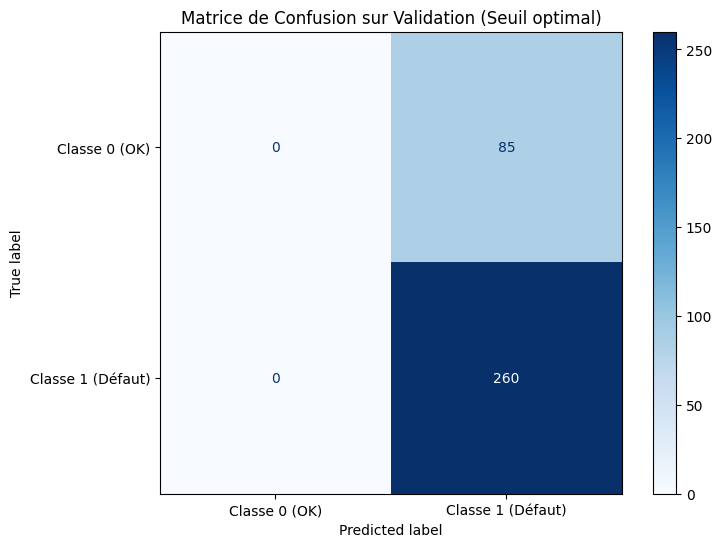

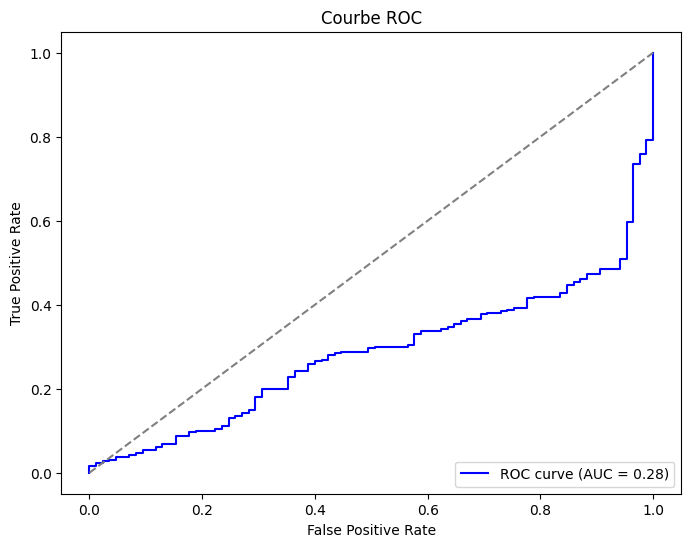

In [9]:
# Ajout de la courbe ROC, AUC et Precision-Recall après l'entraînement

y_true = []
y_scores = []

# On extrait les prédictions et les vraies valeurs une seule fois clairement :
for x_batch, y_batch in val_dataset:
    y_true.extend(y_batch.numpy())  
    y_scores.extend(model.predict(x_batch).flatten())  

y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calcul de la courbe ROC
fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calcul de la courbe Precision-Recall pour seuil optimal selon Recall minimal
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)

# On fixe un Recall minimum (99% pour protéger au maximum la réputation)
recall_min = 0.99

# Trouver le seuil optimal correspondant au Recall minimal requis
optimal_threshold = pr_thresholds[np.where(recall >= recall_min)[0][-1]]

optimal_threshold = 0.7

print(f"✅ Seuil optimal pour Recall ≥ {recall_min*100:.1f}% : {optimal_threshold:.4f}")

# Prédictions finales avec seuil optimal
y_pred_optimal = (y_scores >= optimal_threshold).astype(int)

# Calcul et affichage clair de la matrice de confusion
cm = confusion_matrix(y_true, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Classe 0 (OK)', 'Classe 1 (Défaut)'])

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Matrice de Confusion sur Validation (Seuil optimal)')
plt.show()

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()




## 4. Évaluation sur le même dataset

In [11]:
# Obtenir les probabilités des prédictions sur le test set
y_scores_test = model.predict(X_test).flatten()  # Sorties sigmoïdes entre 0 et 1

# Appliquer le seuil optimal trouvé avec la courbe ROC  
y_pred_test = (y_scores_test >= optimal_threshold).astype(int)

# Calcul des métriques
accuracy = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)  # Ajout du F1-score

# Affichage des résultats
print(f"Accuracy avec seuil optimal ({optimal_threshold:.4f}) : {accuracy:.4f}")
print(f"Précision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 703ms/step
Accuracy avec seuil optimal (0.7000) : 0.7526
Précision : 0.7526
Recall : 1.0000
F1-score : 0.8588
